 # Applying phase balancing using switchers in a simulation based on the Dataset of the ACN in 2019 using OpenDSS

## 1. Importing the necessary libraries

In [1]:
import win32com.client
dssObj = win32com.client.Dispatch("OpenDSSEngine.DSS")
dssText = dssObj.Text
dssCircuit = dssObj.ActiveCircuit
dssSolution = dssCircuit.Solution
dssElem = dssCircuit.ActiveCktElement
dssBus = dssCircuit.ActiveBus
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import datetime as dt
import math
import cmath
import numpy as np
from tqdm import tqdm

## 2. Compile the Master.DSS file for one time to activate Python interfacing 

In [2]:
dssText.Command = "compile 'C:/Users/lazhe/OneDrive/Thesis/OpenDSS/OpenDSS_simulations/1_Yearly_simulation_with_lines_losses/Master.DSS'"

## 3. Loading the Dataset to a dicionary called "data"

In [3]:
file_list = os.listdir("Dataset")
data = {}
for file in file_list:
    data[file[3:9].lower()] = pd.read_csv("Dataset/" + file)

## 4. Running the simulation 

The simulation is done with a 10 minutes timestamp for the whole year of 2019, so the total number of simulation number is 52560 points.

To assign the charging session to its approprate phases, we dectect in every begining of a charging session the two phases that have the lowest power and assign it to them.

P.S. 1: The OpenDSS simulatin using Python interfacing is a bit different than using only OpenDSS. Using only OpenDSS, the whole Dataset is fed to OpenDSS and we set the mode to yearly simulation and fix the timestamp and the total number of the time serie. In the case of Python interfacing, OpenDSS is called by a Python script to run a "Snap mode" simulation (simulation of a fixed values of the load power), then we change the values of the load power each timestamp depending on the Dataset. That's why the is a main loop that iterate over the Dataset to change the values and run a "Snap mode" simulation with OpenDSS every timestamp.

P.S. 2: You can skip the simulation and play around directly with the results, because they are already saved in a csv file and the simulation takes around 25 minutes (in my computer) to be done.

In [4]:
result = pd.DataFrame()                                                    #Initialize the result DataFrame 
losses = pd.DataFrame()                                                    #Initialize the losses DataFrame
voltages = pd.DataFrame()                                                  #Initialize the voltages DataFrame 
n_sim_pt = data["ca-148"].shape[0]                                         #Number of simulation points
kW_P1 = 0                                                                  #Initialize the power of the phase one of the transformer t1 to 0 (this doesn't affect the simulation beacause the results are saved ones the main loop begins)
kW_P2 = 0                                                                  #Initialize the power of the phase tow of the transformer t1 to 0 (this doesn't affect the simulation beacause the results are saved ones the main loop begins)
kW_P3 = 0                                                                  #Initialize the power of the phase three of the transformer t1 to 0 (this doesn't affect the simulation beacause the results are saved one the main begins)
station_bus = {}                                                           #Define the station_bus dictionary that contains the bus number of each station
station_kW = {}                                                            #Define the station_kW dictionary that contain the power of each station
station_phases = {}                                                        #Define the station_phases dictionary that contains the phases of each station
for station in data:                                                       #Initializing station_kW dictionary zeros (this doesn't affect the simulation beacause the results are saved ones the main loop begins)
    station_kW[station] = 0
for i,station in zip(range(1,len(data) + 1),data):                         #Initializing station_bus dictionary zeros (this doesn't affect the simulation beacause the results are saved ones the main loop begins)
    station_bus[station] = str(i)
for station in data:                                                       #Initializing station_phases dictionary zeros (this doesn't affect the simulation beacause the results are saved ones the main loop begins)
    station_phases[station] = ".1.2"
loop = tqdm(total=n_sim_pt, position=0, leave=False)
for i in range(n_sim_pt):                                                  #The main for loop that iterate over the total simulation point
    loop.set_description("Running simulation...".format(i))
    loop.update(1)
    for station in data:                                                   #for loop that that iterates over the  stations
        prev_station_kW = station_kW[station]                              #Get the previous value of the station power to be used later to dectect the begning of a new charging session
        station_kW[station] = str(float(data[station].iloc[i,0]) * 0.001)  #Convert the power from W to kW
        if float(prev_station_kW) == 0 and float(station_kW[station]) > 0: #Dectect a new charging session begining when the previous station power in null and the new one is non zero
            if max(kW_P1,kW_P2,kW_P3) == kW_P1:                            #Dectect which two phases of the transformer t1 that have the lowes power by knowing the maximum one and then the lowest ones are the others
                station_phases[station] = ".2.3"                           #Affect the charging session to the two phases that have the lowest power
            if max(kW_P1,kW_P2,kW_P3) == kW_P2:
                station_phases[station] = ".1.3"
            if max(kW_P1,kW_P2,kW_P3) == kW_P3:
                station_phases[station] = ".1.2"
        dssText.Command = 'Edit "Load.' + station + '" kW=' + station_kW[station] + ' bus1=' + station_bus[station] + station_phases[station]  #Change the power of the station "station" to its new value of power "station_kW" and phase numbers "station_phases[station]""
    dssSolution.Solve()                                                    #Run a Snap mode simulation
    dssText.Command = 'Export p_byphase'                                   #Export the powers per phase to a csv file to be used later
    dssText.Command = 'Export losses'                                      #Export lines losses to a csv file to be used later
    dssText.Command = 'Export ElemVoltages'
    f = pd.read_csv("ACN_Infrastructure_EXP_P_BYPHASE.csv", nrows=1, header=87)#from the exported csv file
    kW_P1 = f.iloc[0,4]                                                    #Set the new value of power of the phase one of the transformer t1
    kW_P2 = f.iloc[0,6]                                                    #Set the new value of power of the phase two of the transformer t1
    kW_P3 = f.iloc[0,8]                                                    #Set the new value of power of the phase three of the transformer t1
    result = result.append(pd.DataFrame({"P1 (kW)" : [kW_P1], "P2 (kW)" : [kW_P2], "P3 (kW)" : [kW_P3]}))#Saving the result in Pandas DataFrame
    f1 = pd.read_csv("ACN_Infrastructure_EXP_LOSSES.csv")                  #Reading the losses results 
    loss_1 = f1.iloc[1,4]                                                  #losses in the lines of type 1 (only one line)
    l2 = [4, 5]                                                            #List of the indices of the type 2 lines in "ACN_Infrastructure_EXP_LOSSES.csv"
    loss_2 = [f1.iloc[i,1] for i in l2]                                    #List of the losses in the lines of type 2
    l3 = [1, 2, 10, 11, 12, 21, 22, 23]                                    #List of the indices of the type 3 lines in "ACN_Infrastructure_EXP_LOSSES.csv"
    loss_3 = [f1.iloc[i,1] for i in l3]                                    #List of the losses in the lines of type 3
    l4 = [6, 7, 8, 9, 32, 33, 34, 35, 46, 47, 48,
          49, 59, 60, 61, 62, 73, 74, 75, 76]                              #List of the indices of the type 4 lines in "ACN_Infrastructure_EXP_LOSSES.csv"
    loss_4 = [f1.iloc[i,1] for i in l4]                                    #List of the losses in the lines of type 4
    l5 = [13, 14, 15, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 
          29, 30, 31, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 
          50, 51, 52, 53, 54, 55, 56, 57, 58, 63, 64, 65, 66, 
          67, 68, 69, 70, 71, 72, 77, 78, 79, 80, 81, 82, 83, 84, 85]      #List of the indices of the type 5 lines in "ACN_Infrastructure_EXP_LOSSES.csv"
    loss_5 = [f1.iloc[i,4] for i in l5]                                    #List of the losses in the lines of type 5
    loss = [f1.iloc[i,1] for i in range(1,86)]                             #List of the losses in each line
    d = {"Type 1 lines losses (W)" : [loss_1],                             
         "Type 2 lines losses (W)" : [sum(loss_2)],  
         "Type 3 lines losses (W)" : [sum(loss_3)], 
         "Type 4 lines losses (W)" : [sum(loss_4)], 
         "Type 5 lines losses (W)" : [sum(loss_5)], 
         "Total lines losses (W)" : [sum(loss)]}                           #Dictionary that contains losses in different types of lines to be fed to "losses" DataFrame 
    losses = losses.append(pd.DataFrame(d))                                #Appending the dictionary to "losses" dataframe
    f2 = pd.read_csv("ACN_Infrastructure_EXP_ElemVoltages.csv", nrows=1, header=88)
    voltages = voltages.append(pd.DataFrame({"V1 (V)" : [f2.iloc[0,3]],
                                             "Ang1 (°)" : [f2.iloc[0,4]],
                                             "V2 (V)" : [f2.iloc[0,7]],
                                             "Ang2 (°)" : [f2.iloc[0,8]],
                                             "V3 (V)" : [f2.iloc[0,5]],
                                             "Ang3 (°)" : [f2.iloc[0,6]]}))

Running simulation...: 100%|███████████████████████████████████████████████████| 52560/52560 [1:05:43<00:00, 13.03it/s]

In [5]:
result.to_csv("result(Yearly_simulation_2019_with_phase_balancing).csv")#Save the result DataFrame to a csv file

In [6]:
losses.to_csv("Lines_losses(with_phase_balancing).csv")

In [7]:
voltages.to_csv("Voltages(with_phase_balancing).csv")

## 5. Plotting the results
Plotting the results with and without the phase balaning

P.S: You can skip the simulation and play around directly with the results, because they are already saved in a csv file.

In [8]:
result1 = pd.read_csv("result(Yearly_simulation_2019).csv") #Loading the results without phase balancing from the csv file 
result2 = pd.read_csv("result(Yearly_simulation_2019_with_phase_balancing).csv") #Loading the results with phase balancing from the csv file 

Set the begin and the end date (year, month, day, hour, minute) to plot the desired portion of the year, beacause when plotting the whole year you can't see clearly the results

In [9]:
dates = []
d0 = dt.datetime(2019, 1, 1)
begin = input("From (year/month/day/hour/minute):")
end = input("To (year/month/day/hour/minute):")
begindt = dt.datetime.strptime(begin, "%Y/%m/%d/%H/%M")
enddt = dt.datetime.strptime(end, "%Y/%m/%d/%H/%M")
begin_delta = begindt - d0
end_delta = enddt - d0
b = int(begin_delta.total_seconds()/60/10)
e = int(end_delta.total_seconds()/60/10)
dates = [begindt + dt.timedelta(minutes = 10 * i) for i in range(e - b)]

From (year/month/day/hour/minute):2019/04/17/00/00
To (year/month/day/hour/minute):2019/04/18/00/00


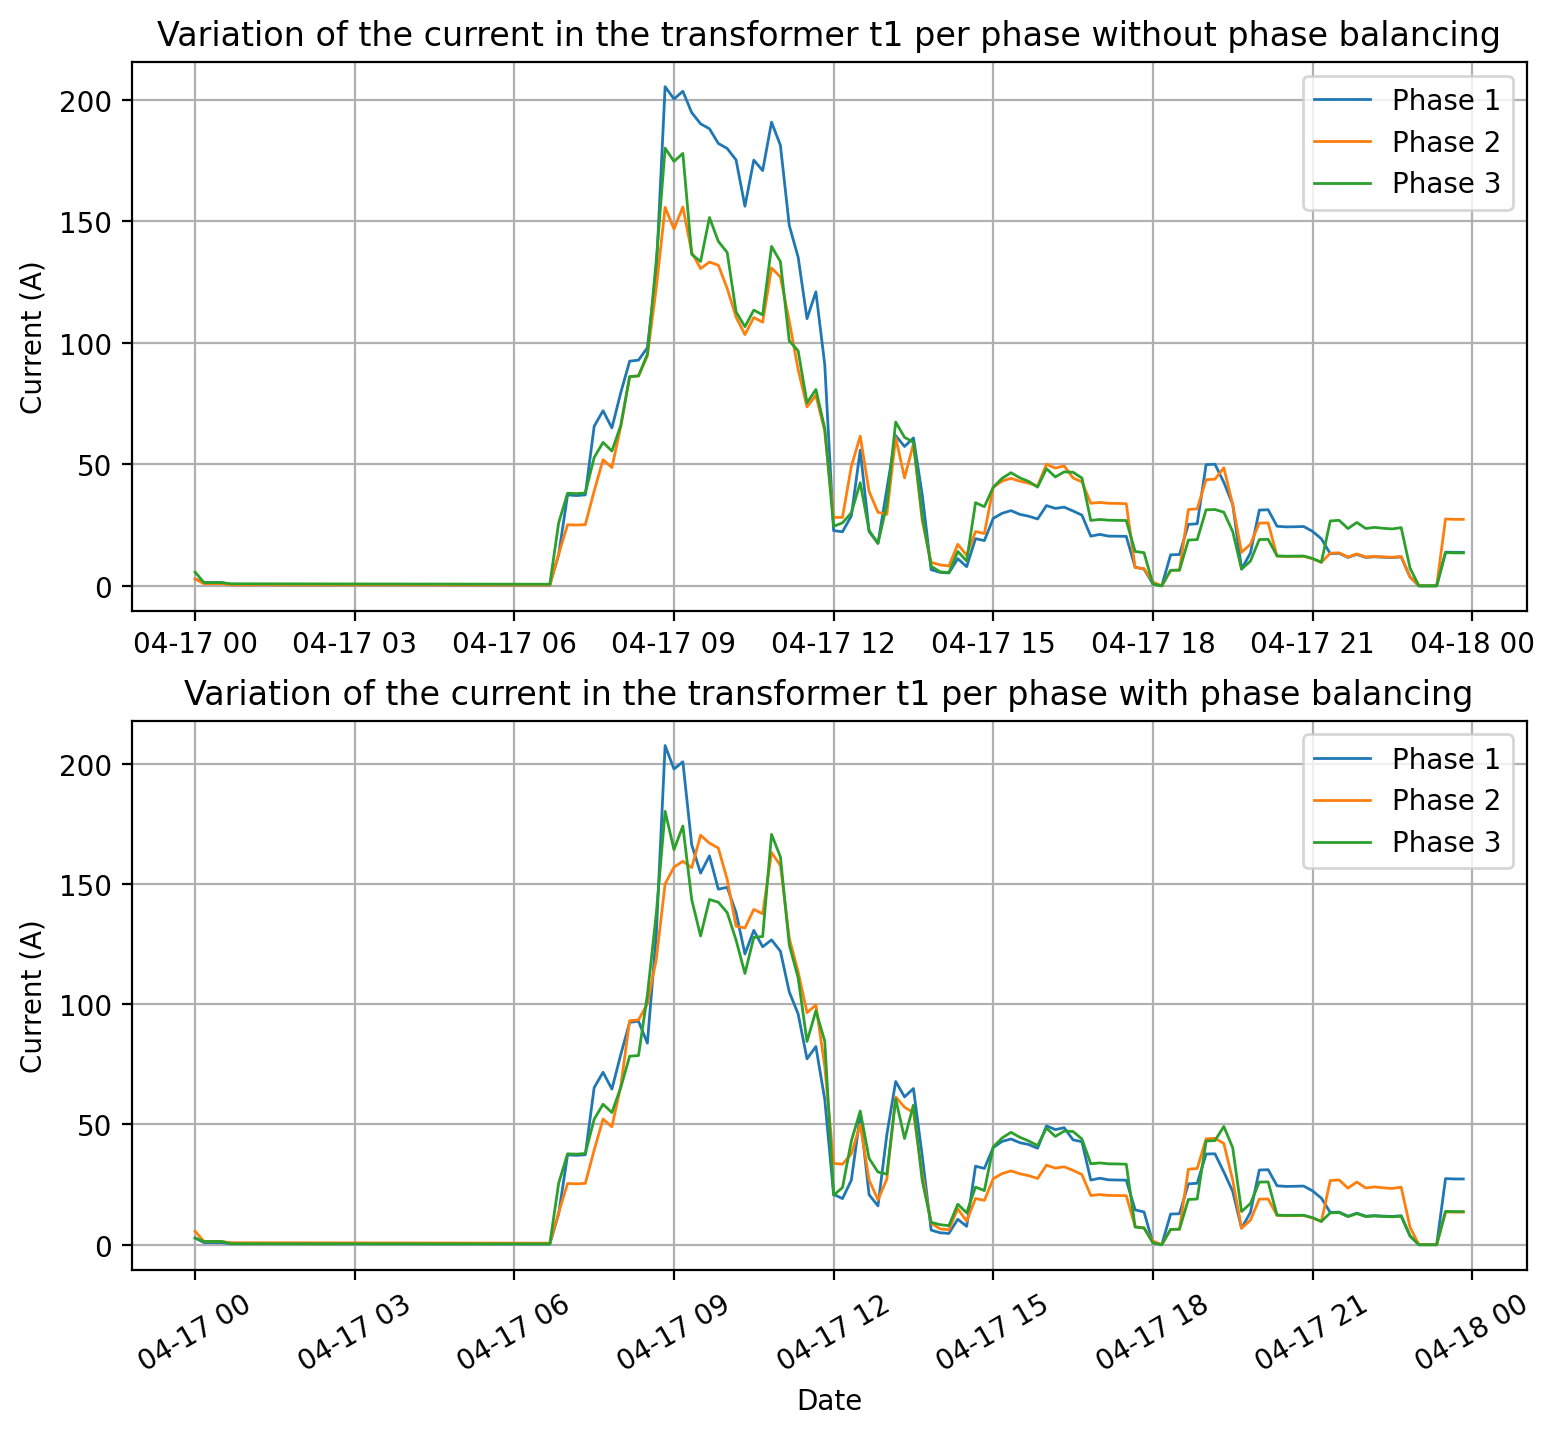

In [10]:
figure(figsize=(9, 8), dpi=200)
plt.subplot(2,1,1)
plt.plot(dates,result1["P1 (kW)"][b:e] * 1000 / 120, linewidth=1, label = "Phase 1")
plt.plot(dates,result1["P2 (kW)"][b:e] * 1000 / 120, linewidth=1, label = "Phase 2")
plt.plot(dates,result1["P3 (kW)"][b:e] * 1000 / 120, linewidth=1, label = "Phase 3")
plt.ylabel("Current (A)")
plt.title("Variation of the current in the transformer t1 per phase without phase balancing")
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(dates,result2["P1 (kW)"][b:e] * 1000 / 120, linewidth=1, label = "Phase 1")
plt.plot(dates,result2["P2 (kW)"][b:e] * 1000 / 120, linewidth=1, label = "Phase 2")
plt.plot(dates,result2["P3 (kW)"][b:e] * 1000 / 120, linewidth=1, label = "Phase 3")
plt.xlabel("Date")
plt.xticks(rotation=30) 
plt.ylabel("Current (A)")
plt.title("Variation of the current in the transformer t1 per phase with phase balancing")
plt.grid()
plt.legend()
plt.show()

## 6. Plotting the lines losses

There is five types of lines used in the ACN infrastructure. We would like to see the losses in each type of them, and the total losses. 

In [11]:
losses2 = pd.read_csv("Lines_losses(with_phase_balancing).csv") #Loading the line losses from the csv file
losses1 = pd.read_csv("Lines_losses.csv") #Loading the line losses from the csv file

Set the begin and the end date (year, month, day, hour, minute) to plot the desired portion of the year, beacause when plotting the whole year you can't see clearly the results

In [13]:
dates = []
d0 = dt.datetime(2019, 1, 1)
begin = input("From (year/month/day/hour/minute):")
end = input("To (year/month/day/hour/minute):")
begindt = dt.datetime.strptime(begin, "%Y/%m/%d/%H/%M")
enddt = dt.datetime.strptime(end, "%Y/%m/%d/%H/%M")
begin_delta = begindt - d0
end_delta = enddt - d0
b = int(begin_delta.total_seconds()/60/10)
e = int(end_delta.total_seconds()/60/10)
dates = [begindt + dt.timedelta(minutes = 10 * i) for i in range(e - b)]

From (year/month/day/hour/minute):2019/04/17/00/00
To (year/month/day/hour/minute):2019/04/18/00/00


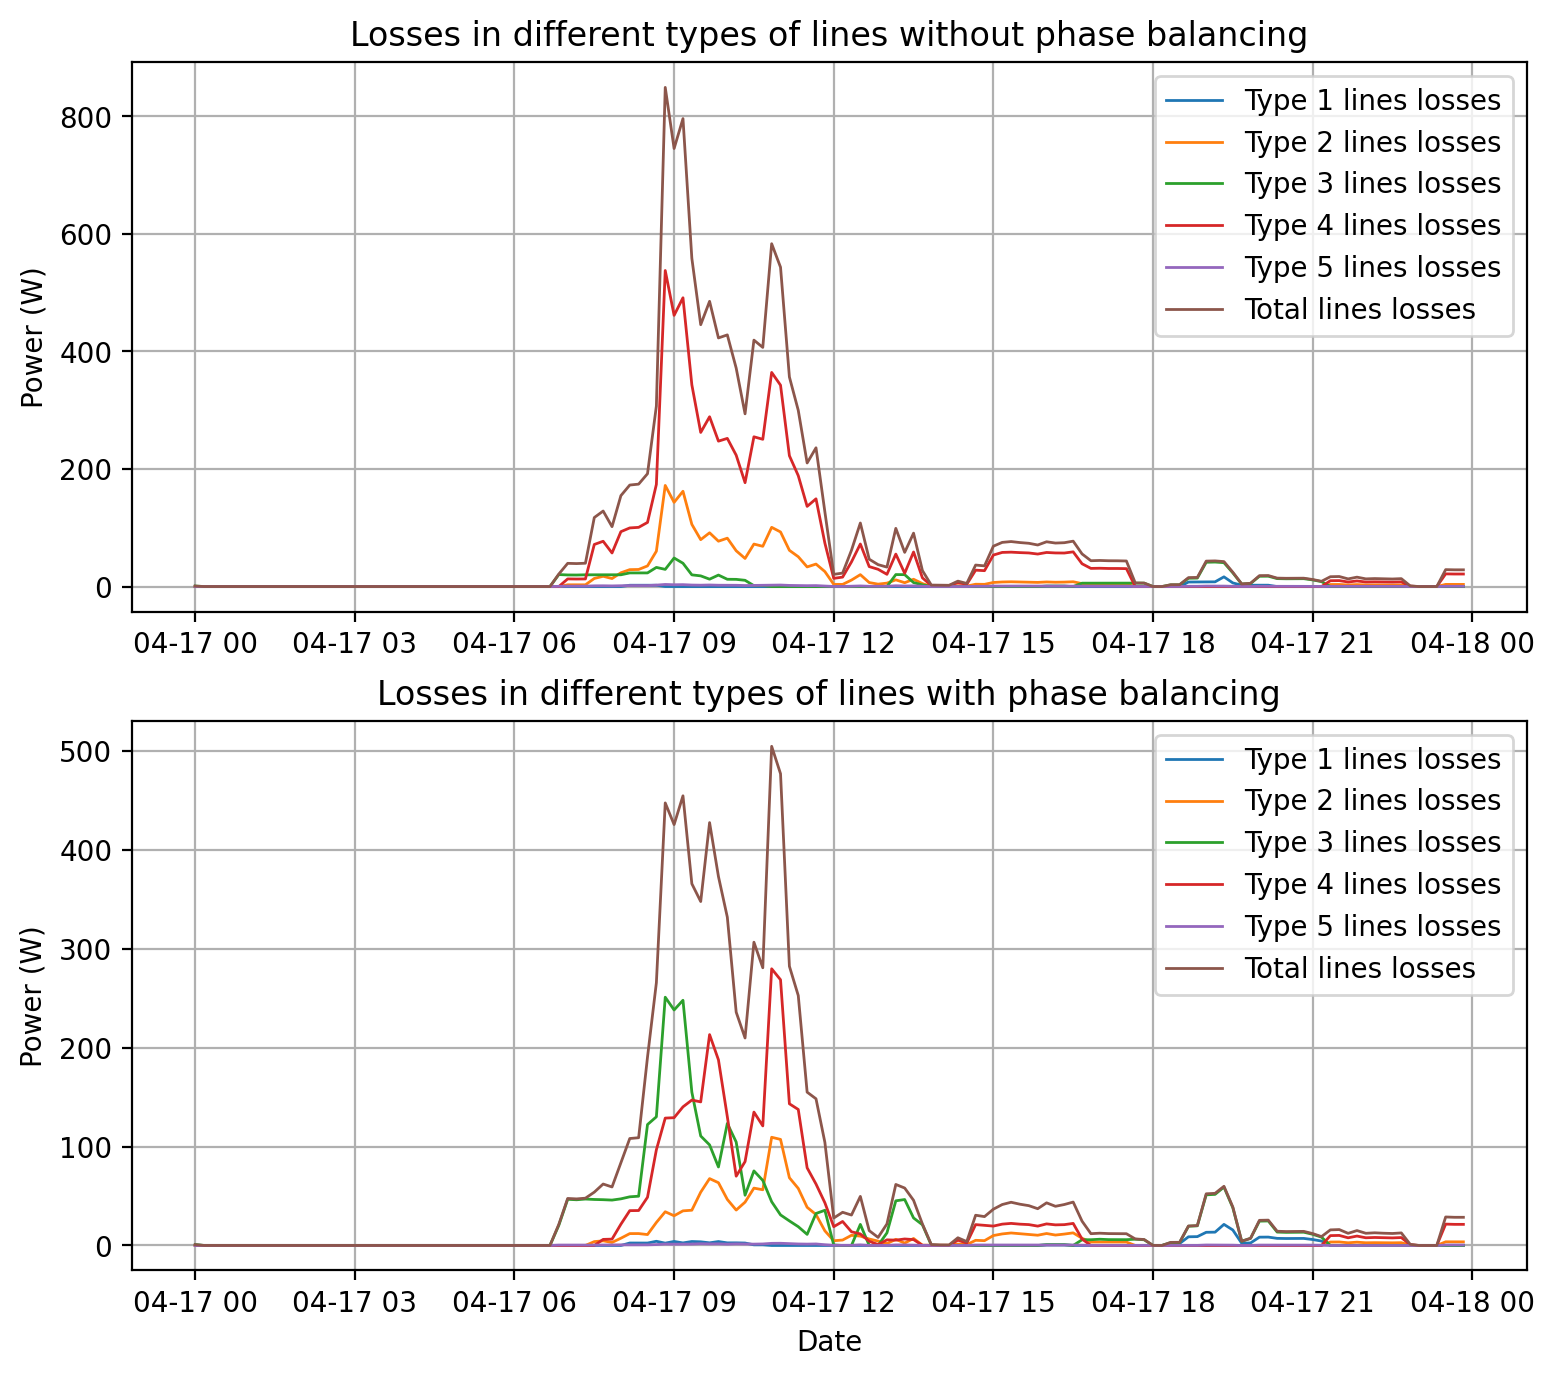

In [12]:
figure(figsize=(9, 8), dpi=200)
######################################################################################################
plt.subplot(2,1,1)
plt.plot(dates,losses1["Type 1 lines losses (W)"][b:e], linewidth=1, label = "Type 1 lines losses")
plt.plot(dates,losses1["Type 2 lines losses (W)"][b:e], linewidth=1, label = "Type 2 lines losses")
plt.plot(dates,losses1["Type 3 lines losses (W)"][b:e], linewidth=1, label = "Type 3 lines losses")
plt.plot(dates,losses1["Type 4 lines losses (W)"][b:e], linewidth=1, label = "Type 4 lines losses")
plt.plot(dates,losses1["Type 5 lines losses (W)"][b:e], linewidth=1, label = "Type 5 lines losses")
plt.plot(dates,losses1["Total lines losses (W)"][b:e], linewidth=1, label = "Total lines losses")
plt.ylabel("Power (W)")
plt.title("Losses in different types of lines without phase balancing")
plt.grid()
plt.legend()
######################################################################################################
plt.subplot(2,1,2)
plt.plot(dates,losses2["Type 1 lines losses (W)"][b:e], linewidth=1, label = "Type 1 lines losses")
plt.plot(dates,losses2["Type 2 lines losses (W)"][b:e], linewidth=1, label = "Type 2 lines losses")
plt.plot(dates,losses2["Type 3 lines losses (W)"][b:e], linewidth=1, label = "Type 3 lines losses")
plt.plot(dates,losses2["Type 4 lines losses (W)"][b:e], linewidth=1, label = "Type 4 lines losses")
plt.plot(dates,losses2["Type 5 lines losses (W)"][b:e], linewidth=1, label = "Type 5 lines losses")
plt.plot(dates,losses2["Total lines losses (W)"][b:e], linewidth=1, label = "Total lines losses")
plt.ylabel("Power (W)")
plt.title("Losses in different types of lines with phase balancing")
plt.grid()
plt.legend()
plt.xlabel("Date")
######################################################################################################
plt.show()

## 7. Plotting the Vrms

In [13]:
voltages1 = pd.read_csv("voltages.csv")
voltages2 = pd.read_csv("voltages(with_phase_balancing).csv")

Set the begin and the end date (year, month, day, hour, minute) to plot the desired portion of the year, beacause when plotting the whole year you can't see clearly the results

In [4]:
dates = []
d0 = dt.datetime(2019, 1, 1)
begin = input("From (year/month/day/hour/minute):")
end = input("To (year/month/day/hour/minute):")
begindt = dt.datetime.strptime(begin, "%Y/%m/%d/%H/%M")
enddt = dt.datetime.strptime(end, "%Y/%m/%d/%H/%M")
begin_delta = begindt - d0
end_delta = enddt - d0
b = int(begin_delta.total_seconds()/60/10)
e = int(end_delta.total_seconds()/60/10)
dates = [begindt + dt.timedelta(minutes = 10 * i) for i in range(e - b)]

From (year/month/day/hour/minute):2019/04/17/00/00
To (year/month/day/hour/minute):2019/04/18/00/00


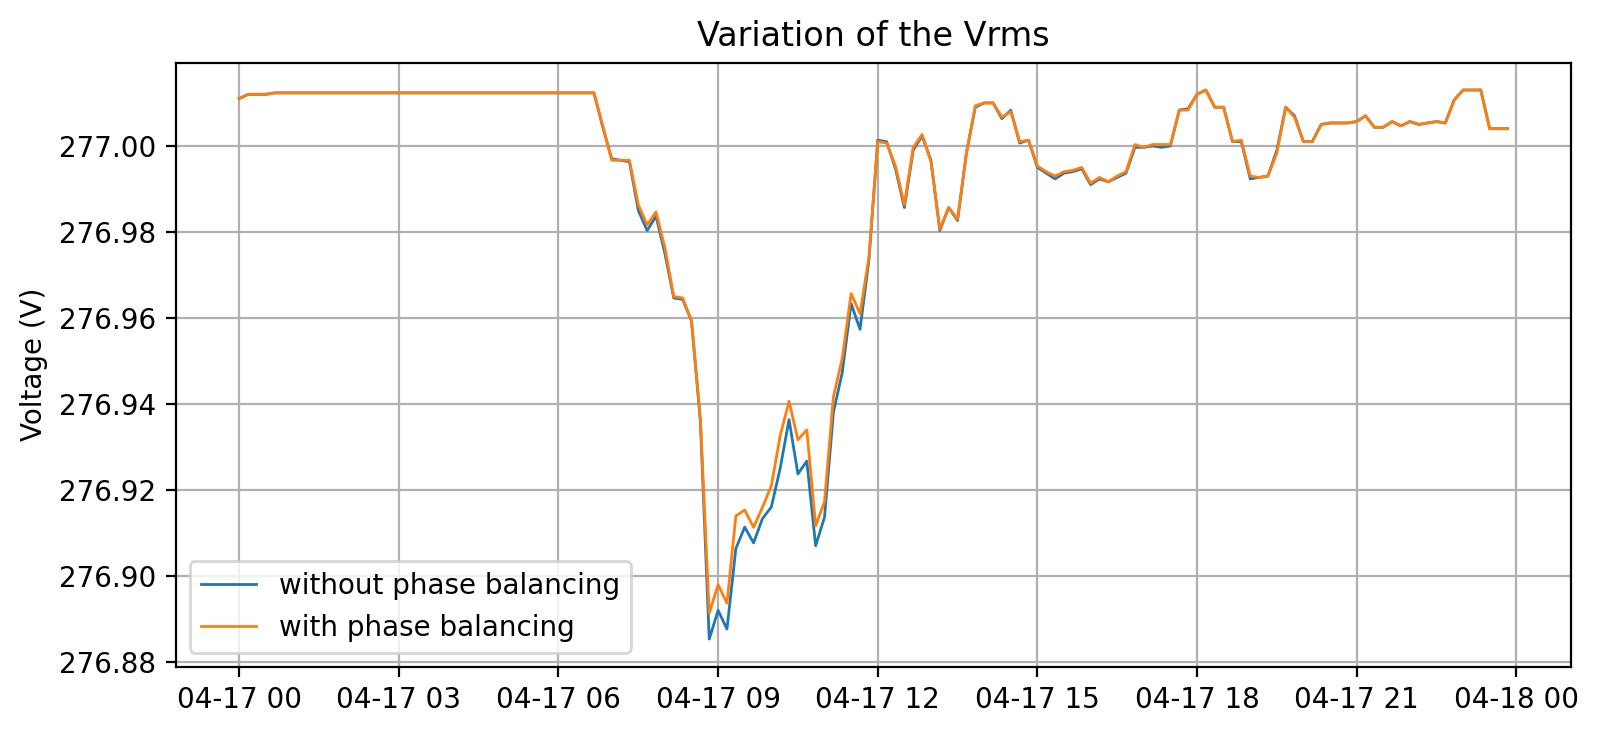

In [14]:
figure(figsize=(9, 4), dpi=200)
plt.plot(dates, np.sqrt((voltages1["V1 (V)"][b:e] ** 2 + voltages1["V2 (V)"][b:e] ** 2 + voltages1["V3 (V)"][b:e] ** 2) / 3), linewidth=1, label = "without phase balancing")       
plt.plot(dates, np.sqrt((voltages2["V1 (V)"][b:e] ** 2 + voltages2["V2 (V)"][b:e] ** 2 + voltages2["V3 (V)"][b:e] ** 2) / 3), linewidth=1, label = "with phase balancing")
plt.ylabel("Voltage (V)")
plt.title("Variation of the Vrms")
plt.legend()
plt.grid()
plt.show()

## 8. Plotting the phase angle between voltage phases

Set the begin and the end date (year, month, day, hour, minute) to plot the desired portion of the year, beacause when plotting the whole year you can't see clearly the results

In [ ]:
dates = []
d0 = dt.datetime(2019, 1, 1)
begin = input("From (year/month/day/hour/minute):")
end = input("To (year/month/day/hour/minute):")
begindt = dt.datetime.strptime(begin, "%Y/%m/%d/%H/%M")
enddt = dt.datetime.strptime(end, "%Y/%m/%d/%H/%M")
begin_delta = begindt - d0
end_delta = enddt - d0
b = int(begin_delta.total_seconds()/60/10)
e = int(end_delta.total_seconds()/60/10)
dates = [begindt + dt.timedelta(minutes = 10 * i) for i in range(e - b)]

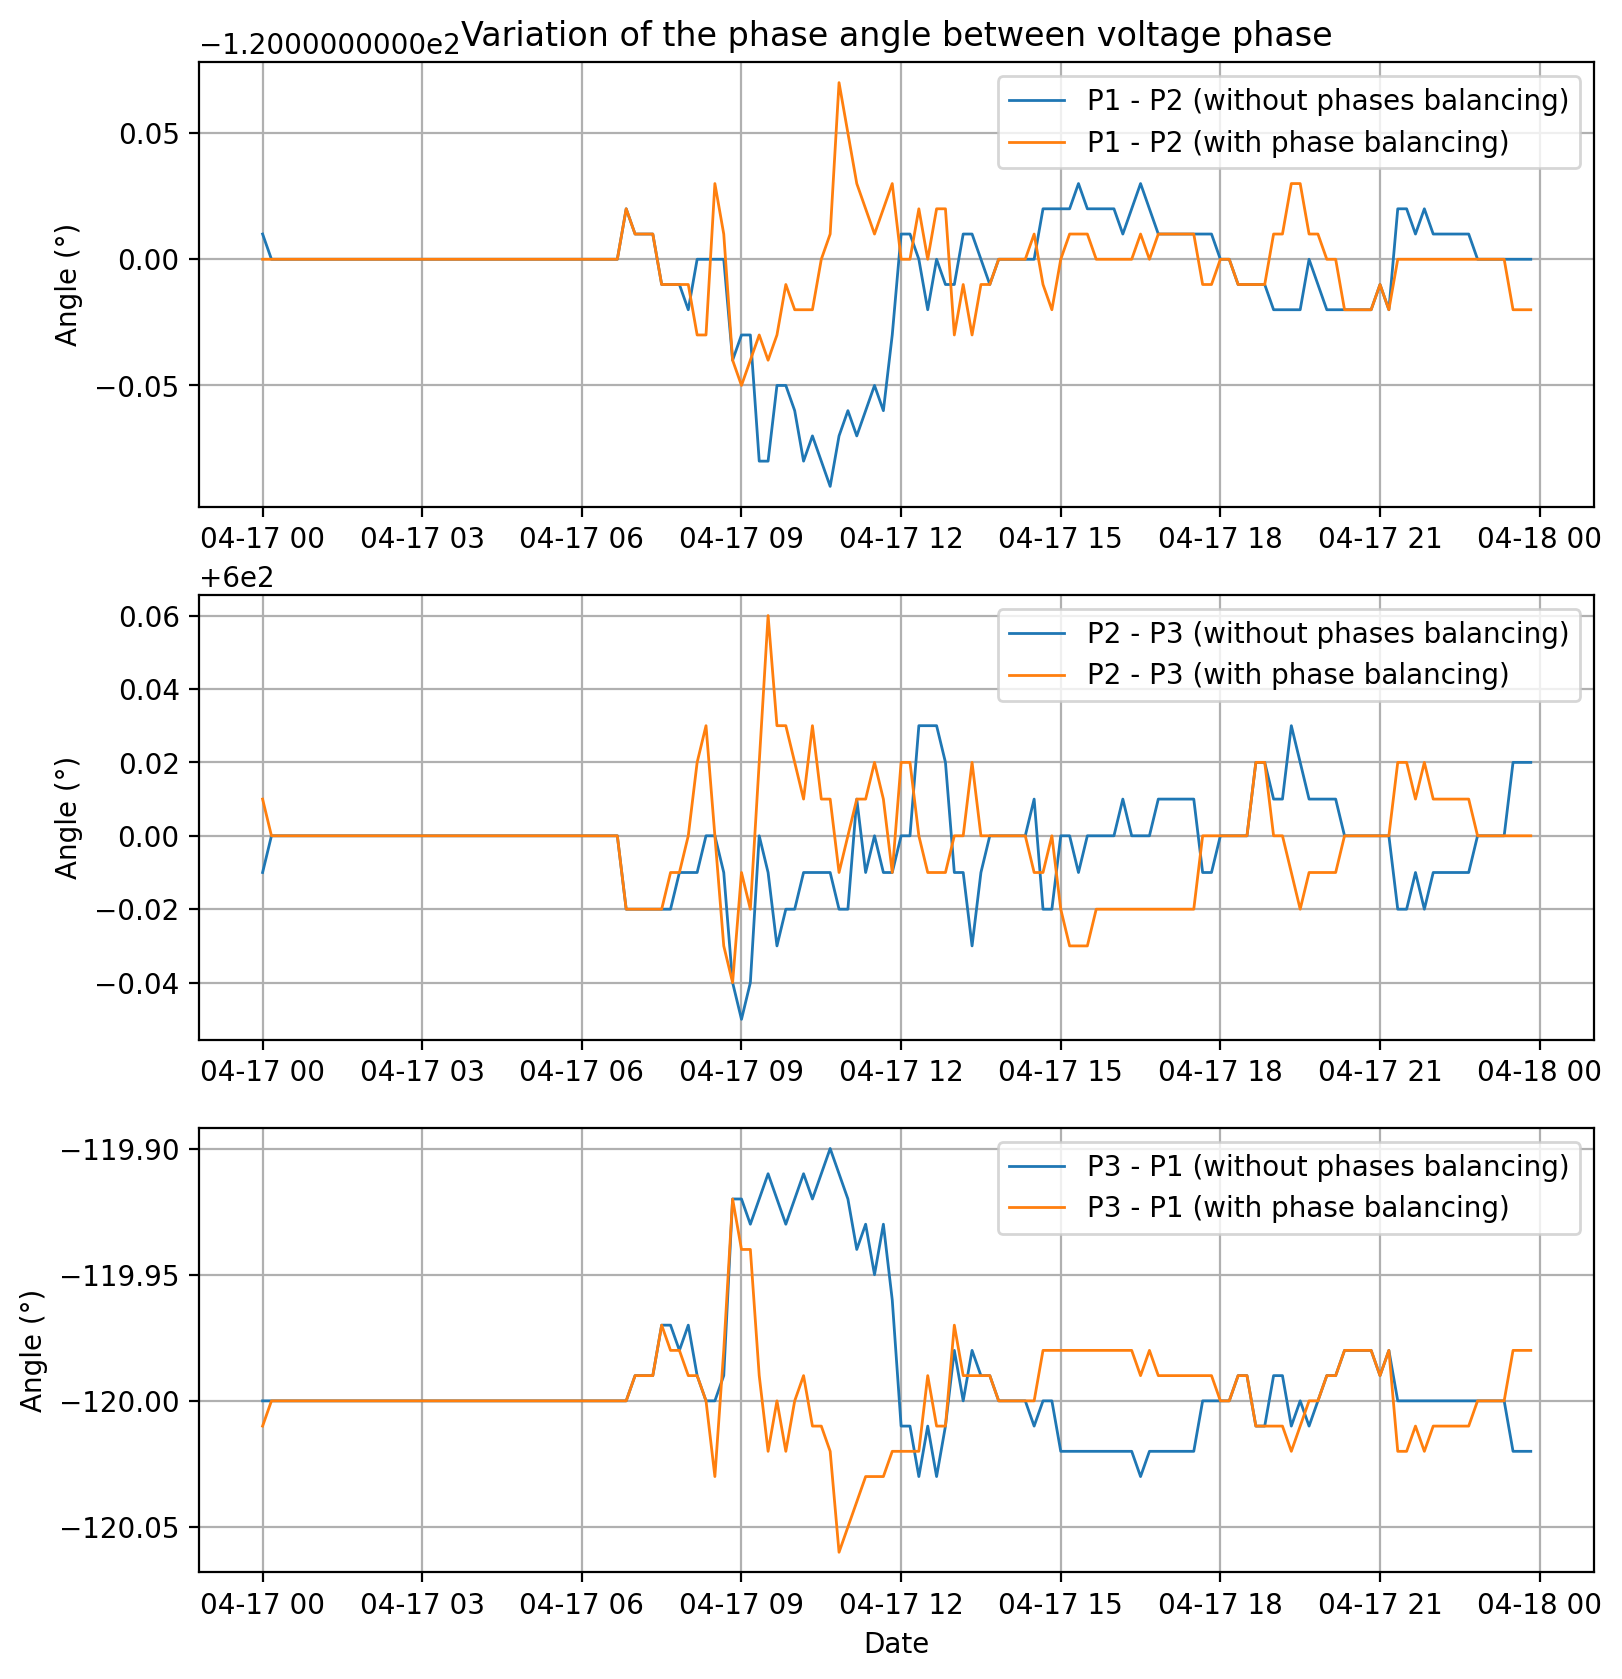

In [15]:
figure(figsize=(9, 10), dpi=200)
###########################################################################################################################################
plt.subplot(3,1,1)
plt.plot(dates, voltages1["Ang1 (°)"][b:e] - voltages1["Ang2 (°)"][b:e], linewidth=1, label = "P1 - P2 (without phases balancing)")                    
plt.plot(dates, voltages2["Ang1 (°)"][b:e] - voltages2["Ang2 (°)"][b:e], linewidth=1, label = "P1 - P2 (with phase balancing)")           
plt.ylabel("Angle (°)")
plt.title("Variation of the phase angle between voltage phase")
plt.grid()
plt.legend()
#########################################################################################################################################
plt.subplot(3,1,2)
plt.plot(dates, 360 + voltages1["Ang2 (°)"][b:e] - voltages1["Ang3 (°)"][b:e], linewidth=1, label = "P2 - P3 (without phases balancing)")           
plt.plot(dates, 360 + voltages2["Ang2 (°)"][b:e] - voltages2["Ang3 (°)"][b:e], linewidth=1, label = "P2 - P3 (with phase balancing)")           
plt.ylabel("Angle (°)")
plt.grid()
plt.legend()
##########################################################################################################################################
plt.subplot(3,1,3)
plt.plot(dates, voltages1["Ang3 (°)"][b:e] - voltages1["Ang1 (°)"][b:e], linewidth=1, label = "P3 - P1 (without phases balancing)")           
plt.plot(dates, voltages2["Ang3 (°)"][b:e] - voltages2["Ang1 (°)"][b:e], linewidth=1, label = "P3 - P1 (with phase balancing)")           
plt.xlabel("Date")
plt.ylabel("Angle (°)")
plt.grid()
plt.legend()
#########################################################################################################################################
plt.show()